In [235]:
import cv2
import glob
import numpy as np
from PIL import Image
from PIL.ExifTags import TAGS
from datetime import datetime

from scipy.sparse import lil_matrix
from scipy.optimize import least_squares

import matplotlib.animation as animation
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import pickle
import json
%matplotlib widget


# **Single Camera Calibration**

In [236]:

def calibrate_camera(images_folder, row = 5, col = 7, scale= 4.5,show=False, error_threshold = 1.5):
    images_names = sorted(glob.glob(images_folder))
    
    #criteria used by checkerboard pattern detector.
    #Change this if the code can't find the checkerboard
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
 
    rows = row #number of checkerboard rows.
    columns = col #number of checkerboard columns.
    world_scaling = scale # real world square size.
 
    #coordinates of squares in the checkerboard world space
    objp = np.zeros((rows*columns,3), np.float32)
    objp[:,:2] = np.mgrid[0:rows,0:columns].T.reshape(-1,2)
    objp = world_scaling* objp

        
    ideal = False
    unideal_images = {}
    
    while not ideal:
        
        i=0
        get = []
        
        images = []
        
        for imname in images_names:
            if imname not in unideal_images.keys():
                im = cv2.imread(imname, 1)
                images.append(im)
        
        #frame dimensions. Frames should be the same size.
        width = images[0].shape[1]
        height = images[0].shape[0]
        
        #Pixel coordinates of checkerboards
        imgpoints = [] # 2d points in image plane.
    
        #coordinates of the checkerboard in checkerboard world space.
        objpoints = [] # 3d point in real world space
            
        for frame in images:
            
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # detectChessboardflags = (cv2.CALIB_CB_ACCURACY  
            # + cv2.CALIB_CB_EXHAUSTIVE  
            # + cv2.CALIB_CB_NORMALIZE_IMAGE)
    
            # ret, corners = cv2.findChessboardCornersSB(gray, (rows, columns), detectChessboardflags)

            flags = (cv2.CALIB_CB_ADAPTIVE_THRESH  
            + cv2.CALIB_CB_FAST_CHECK  
            + cv2.CALIB_CB_NORMALIZE_IMAGE)
    
            #find the checkerboard
            ret, corners = cv2.findChessboardCorners(gray, (rows, columns), flags)
    
    
            if ret == True:
                get.append(images_names[i])
                #Convolution size used to improve corner detection. Don't make this too large.
                conv_size = (11, 11)
    
                #opencv can attempt to improve the checkerboard coordinates
                corners = cv2.cornerSubPix(gray, corners, conv_size, (-1, -1), criteria)
                cv2.drawChessboardCorners(frame, (rows,columns), corners, ret)
                
                if show:
                    cv2.imshow('img', frame)
                    
                    if cv2.waitKey(0) & 0xFF == ord('q'):
                        show = False
                
                    
    
                objpoints.append(objp)
                imgpoints.append(corners)
            i += 1
    
        cv2.destroyAllWindows()

        
   
        yes =  cv2.calibrateCameraExtended(
            objpoints, 
            imgpoints, 
            (width, height), 
            None, 
            None,
            flags=cv2.CALIB_RATIONAL_MODEL
            )
        
        unideal_detected = False
        for j , error in enumerate(yes[-1]):
            if error >= error_threshold:
                unideal_detected = True
                unideal_images[get[j]] = error
        
        if not unideal_detected:
            ideal = True
    
    print('detected {n} :'.format(n=len(get)))        
    print("RMSE :", yes[0])
    e = 0
    for b in get:
        print(b,":",yes[-1][e])
        e +=1
    print("Unideal Images:")
    print(unideal_images)
        
    return yes
 


In [237]:
# mtx, dist = calibrate_camera(images_folder = './data/1/*')
yes1 = calibrate_camera(images_folder = './data/k2/m/mono/*')
mtx_m,dist_m = yes1[1],yes1[2]
print("Camera Matrix", mtx_m)
print("Distortion Matrix", dist_m)

detected 12 :
RMSE : 0.3188824467580522
./data/k2/m/mono\IMG_20230607_094327.jpg : [0.20524449]
./data/k2/m/mono\IMG_20230607_094331.jpg : [0.27293389]
./data/k2/m/mono\IMG_20230607_094335.jpg : [0.28384838]
./data/k2/m/mono\IMG_20230607_094339.jpg : [0.2854551]
./data/k2/m/mono\IMG_20230607_094343.jpg : [0.28295238]
./data/k2/m/mono\IMG_20230607_094347.jpg : [0.25115188]
./data/k2/m/mono\IMG_20230607_094352.jpg : [0.38606883]
./data/k2/m/mono\IMG_20230607_094356.jpg : [0.32903022]
./data/k2/m/mono\IMG_20230607_094410.jpg : [0.2408523]
./data/k2/m/mono\IMG_20230607_094414.jpg : [0.44509648]
./data/k2/m/mono\IMG_20230607_094420.jpg : [0.36061386]
./data/k2/m/mono\IMG_20230607_094424.jpg : [0.39363314]
Unideal Images:
{}
Camera Matrix [[1.43685473e+03 0.00000000e+00 9.51710378e+02]
 [0.00000000e+00 1.43760505e+03 5.48900808e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Matrix [[ 6.37019460e+00 -4.65764597e+01  2.20637978e-03 -1.16933464e-03
   1.38793941e+02  6.3895754

In [238]:
# mtx, dist = calibrate_camera(images_folder = './data/1/*')
yes1 = calibrate_camera(images_folder = './data/k/j/mono/*')
mtx_j,dist_j = yes1[1],yes1[2]

print("Camera Matrix", mtx_j)
print("Distortion Matrix", dist_j)

detected 18 :
RMSE : 0.20179337303308906
./data/k/j/mono\IMG_20230529_105904.jpg : [0.13881654]
./data/k/j/mono\IMG_20230529_105916.jpg : [0.20513747]
./data/k/j/mono\IMG_20230529_105928.jpg : [0.17312852]
./data/k/j/mono\IMG_20230529_105933.jpg : [0.25186026]
./data/k/j/mono\IMG_20230529_105947.jpg : [0.18879454]
./data/k/j/mono\IMG_20230529_105952.jpg : [0.25460425]
./data/k/j/mono\IMG_20230529_110006.jpg : [0.10470776]
./data/k/j/mono\IMG_20230529_110018.jpg : [0.17455415]
./data/k/j/mono\IMG_20230529_110030.jpg : [0.14259216]
./data/k/j/mono\IMG_20230529_110045.jpg : [0.17499664]
./data/k/j/mono\IMG_20230529_110052.jpg : [0.19241862]
./data/k/j/mono\IMG_20230529_110107.jpg : [0.13318791]
./data/k/j/mono\IMG_20230529_110116.jpg : [0.09927887]
./data/k/j/mono\IMG_20230529_110129.jpg : [0.22913217]
./data/k/j/mono\IMG_20230529_110136.jpg : [0.17470888]
./data/k/j/mono\IMG_20230529_110143.jpg : [0.31337315]
./data/k/j/mono\IMG_20230529_110149.jpg : [0.26240383]
./data/k/j/mono\IMG_2023

In [239]:
# mtx, dist = calibrate_camera(images_folder = './data/1/*')
yes1 = calibrate_camera(images_folder = './data/k2/w/mono/*')
mtx_w,dist_w = yes1[1],yes1[2]

print("Camera Matrix", mtx_w)
print("Distortion Matrix", dist_w)

detected 9 :
RMSE : 0.4727283805356513
./data/k2/w/mono\IMG_20230607_094449.jpg : [0.28357556]
./data/k2/w/mono\IMG_20230607_094455.jpg : [0.62535427]
./data/k2/w/mono\IMG_20230607_094459.jpg : [0.37168421]
./data/k2/w/mono\IMG_20230607_094504.jpg : [0.40268635]
./data/k2/w/mono\IMG_20230607_094509.jpg : [0.40709992]
./data/k2/w/mono\IMG_20230607_094513.jpg : [0.77423412]
./data/k2/w/mono\IMG_20230607_094519.jpg : [0.34377641]
./data/k2/w/mono\IMG_20230607_094531.jpg : [0.35805278]
./data/k2/w/mono\IMG_20230607_094543.jpg : [0.47739685]
Unideal Images:
{}
Camera Matrix [[1.34638176e+03 0.00000000e+00 9.83342855e+02]
 [0.00000000e+00 1.34638338e+03 5.30830400e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Matrix [[-1.76354285e+01 -2.63732159e+01  3.62222957e-03  8.46199027e-04
   1.35311337e+03 -1.79418002e+01 -1.86496552e+01  1.30100598e+03
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


# **Single Calibration Result**

In [240]:
def check_calibration(folder_name,mtx,dist):
    images_names = sorted(glob.glob(folder_name))
    images = []
    for imname in images_names:
        im = cv2.imread(imname, 1)

        height, width, channels = im.shape
        newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (width,height), 1, (width,height))
        dst = cv2.undistort(im, mtx, dist, None, newcameramtx)
        # # crop the image
        # x, y, w, h = roi
        # dst = dst[y:y+h, x:x+w]
        
        diff = np.concatenate((im, dst), axis=1)
        cv2.imshow('img', diff)
        if cv2.waitKey(0) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()


In [241]:
# check_calibration('./data/k2/m/mono/*',mtx_m,dist_m)
# check_calibration('./data/k2/j/mono/*',mtx_j,dist_j)
# check_calibration('./data/k2/w/mono/*',mtx_w,dist_w)

# **Stereo Calibration**

In [242]:
def get_images_by_date_taken(folder_name):
    files = sorted(glob.glob(folder_name))
    file_date = {}
    for im in files:
        image = Image.open(im)
        exifdata = image.getexif()

        meta = {}
        # iterating over all EXIF data fields
        for tag_id in exifdata:
            # # get the tag name, instead of human unreadable tag id
            tag = TAGS.get(tag_id, tag_id)
            data = exifdata.get(tag_id)
            # decode bytes 
            if isinstance(data, bytes):
                data = data.decode()
            meta[tag] = data
        file_date[im] = datetime.strptime(meta["DateTime"], "%Y:%m:%d %H:%M:%S")
    return [im for im, _ in sorted(file_date.items(), key=lambda x:x[1])]


In [243]:
def check_image_pair(folder1, folder2):
    c1_images_names = get_images_by_date_taken(folder1)
    c2_images_names = get_images_by_date_taken(folder2)
 
    c1_images = []
    c2_images = []
    for im1, im2 in zip(c1_images_names, c2_images_names):
        _im = cv2.imread(im1, 1)
        c1_images.append(_im)
 
        _im = cv2.imread(im2, 1)
        c2_images.append(_im)
      
    width = c1_images[0].shape[1]
    height = c1_images[0].shape[0]  
    
    i = 0

    for frame1, frame2 in zip(c1_images, c2_images):
        Sres = np.concatenate((frame1, frame2), axis=1)
        
        text = str(i+1) + ' | Camera 1 : ' + str(c1_images_names[i])
        cv2.putText(Sres, text, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (255,255,0), 2, cv2.LINE_AA)
        
        text = str(i+1) + ' | Camera 2 : ' + str(c2_images_names[i])
        cv2.putText(Sres, text, (width+50,50), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (255,255,0), 2, cv2.LINE_AA)
        

        cv2.imshow('Sres', Sres)
        if cv2.waitKey(0) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break
        i += 1
    cv2.destroyAllWindows()


In [244]:
#check_image_pair('./data/k/j/stereo1/*','./data/k/m/stereo1/*')

In [245]:
#check_image_pair('./data/k/j/stereo2/*','./data/k/w/stereo2/*')

In [246]:
#check_image_pair('./data/k/m/stereo3/*','./data/k/w/stereo3/*')

In [247]:

def stereo_calibrate(mtx1, dist1, mtx2, dist2, folder1, folder2, show=False, error_threshold = 1.5):
    #read the synched frames
    c1_images_names = get_images_by_date_taken(folder1)
    c2_images_names = get_images_by_date_taken(folder2)
 
    #change this if stereo calibration not good.
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
 
    rows = 5 #number of checkerboard rows.
    columns = 7 #number of checkerboard columns.
    world_scaling = 4.5 # real world square size.
 
    #coordinates of squares in the checkerboard world space
    objp = np.zeros((rows*columns,3), np.float32)
    objp[:,:2] = np.mgrid[0:rows,0:columns].T.reshape(-1,2)
    objp = world_scaling* objp
 

    ideal = False
    unideal_images = {}
    
    while not ideal:
        
        get = []
        i = 0
        
        
        c1_images = []
        c2_images = []

        for im1, im2 in zip(c1_images_names, c2_images_names):
            if tuple([im1,im2]) not in unideal_images.keys():

                _im = cv2.imread(im1, 1)
                c1_images.append(_im)
        
                _im = cv2.imread(im2, 1)
                c2_images.append(_im)

        if c1_images == [] or c2_images == []:
            print("Calibration Failed! Error Threshold Too Low!")
            break
        
        #frame dimensions. Frames should be the same size.
        width = c1_images[0].shape[1]
        height = c1_images[0].shape[0]
    
        #Pixel coordinates of checkerboards
        imgpoints_left = [] # 2d points in image plane.
        imgpoints_right = []
    
        #coordinates of the checkerboard in checkerboard world space.
        objpoints = [] # 3d point in real world space
    
   
    
        for frame1, frame2 in zip(c1_images, c2_images):
            gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
            gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
                      
            detectChessboardflags = (cv2.CALIB_CB_ACCURACY  
            + cv2.CALIB_CB_EXHAUSTIVE  
            + cv2.CALIB_CB_NORMALIZE_IMAGE)
    
            c_ret1, corners1 = cv2.findChessboardCornersSB(gray1, (rows, columns), detectChessboardflags)
            c_ret2, corners2 = cv2.findChessboardCornersSB(gray2, (rows, columns), detectChessboardflags)
    
    
            if c_ret1 == True and c_ret2 == True:
                get.append([c1_images_names[i],c2_images_names[i]])
                corners1 = cv2.cornerSubPix(gray1, corners1, (11, 11), (-1, -1), criteria)
                corners2 = cv2.cornerSubPix(gray2, corners2, (11, 11), (-1, -1), criteria)
    
                cv2.drawChessboardCorners(frame1, (rows, columns), corners1, c_ret1)
                
    
                cv2.drawChessboardCorners(frame2, (rows, columns), corners2, c_ret2)
                
                
                Sres = np.concatenate((frame1, frame2), axis=1)
                text = str(i+1) + ' | Camera 1 : ' + str(c1_images_names[i])
                cv2.putText(Sres, text, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 
                    1, (255,255,0), 2, cv2.LINE_AA)
                
                text = str(i+1) + ' | Camera 2 : ' + str(c2_images_names[i])
                cv2.putText(Sres, text, (width+50,50), cv2.FONT_HERSHEY_SIMPLEX, 
                    1, (255,255,0), 2, cv2.LINE_AA)
                
                if show:
                    cv2.imshow('Sres', Sres)
                    if cv2.waitKey(0) & 0xFF == ord('q'):
                        show = False
                        cv2.destroyAllWindows()
                
    
                objpoints.append(objp)
                imgpoints_left.append(corners1)
                imgpoints_right.append(corners2)

            i += 1
                
        
        cv2.destroyAllWindows()
        stereocalibration_flags = cv2.CALIB_FIX_INTRINSIC + cv2.CALIB_RATIONAL_MODEL

        ret, CM1, dist1, CM2, dist2, R, T, E, F = cv2.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, mtx1, dist1,
                                                                    mtx2, dist2, (width, height), criteria = criteria, flags = stereocalibration_flags)

        yes_flags = cv2.CALIB_FIX_INTRINSIC + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_USE_EXTRINSIC_GUESS
        yes = cv2.stereoCalibrateExtended(objpoints, imgpoints_left, imgpoints_right, mtx1, dist1,
                                                                    mtx2, dist2, (width, height), R, T, criteria = criteria, flags = yes_flags)
        
        unideal_detected = False
        for j , error in enumerate(yes[-1]):
            if error[0] >= error_threshold or error[1] >= error_threshold:
                unideal_detected = True
                unideal_images[tuple(get[j])] = error
        
        if not unideal_detected:
            ideal = True
        

    print("RMSE :",ret)
    print('detected {n} :'.format(n=len(get)))     
    for k in range(len(get)):
        print("Iter :", k+1)
        print("1st Camera :",get[k][0],"Error :",yes[-1][k][0])
        print("2nd Camera :",get[k][1],"Error :",yes[-1][k][1])
        print()
        
    print("Unideal Images:")
    print(unideal_images)
        
    
    return R, T
    

# Stereo Folder

In [248]:
stereo_lab = 'k4'
stereo_folder = 'stereo'

# Stereo Calibrate

In [249]:
R1, T1 = stereo_calibrate(mtx_j, dist_j, mtx_m, dist_m, './data/'+stereo_lab+'/j/'+stereo_folder+'/*','./data/'+stereo_lab+'/m/'+stereo_folder+'/*',show=False, error_threshold=30)
R1, T1

RMSE : 0.2511974228733127
detected 6 :
Iter : 1
1st Camera : ./data/k4/j/stereo\IMG_StereoDefault1.jpg Error : 0.2698724051288212
2nd Camera : ./data/k4/m/stereo\IMG_StereoDefault1.jpg Error : 0.27684429819809414

Iter : 2
1st Camera : ./data/k4/j/stereo\IMG_StereoDefault1_1.jpg Error : 0.31189078185524194
2nd Camera : ./data/k4/m/stereo\IMG_StereoDefault1_1.jpg Error : 0.30863996225412754

Iter : 3
1st Camera : ./data/k4/j/stereo\IMG_StereoDefault1_2.jpg Error : 0.32023464945376257
2nd Camera : ./data/k4/m/stereo\IMG_StereoDefault1_2.jpg Error : 0.3108777962873191

Iter : 4
1st Camera : ./data/k4/j/stereo\IMG_StereoDefault1_3.jpg Error : 0.24337824333917676
2nd Camera : ./data/k4/m/stereo\IMG_StereoDefault1_3.jpg Error : 0.20646592977623932

Iter : 5
1st Camera : ./data/k4/j/stereo\IMG_StereoDefault1_4.jpg Error : 0.13220233104743995
2nd Camera : ./data/k4/m/stereo\IMG_StereoDefault1_4.jpg Error : 0.14491631561273105

Iter : 6
1st Camera : ./data/k4/j/stereo\IMG_StereoDefault1_5.jpg E

(array([[ 0.99338062, -0.05493314, -0.10088256],
        [ 0.05074544,  0.99775859, -0.0436198 ],
        [ 0.10305262,  0.03821173,  0.99394166]]),
 array([[19.37931576],
        [ 2.5003201 ],
        [ 2.69281151]]))

In [250]:
R2, T2 = stereo_calibrate(mtx_j, dist_j, mtx_w, dist_w, './data/'+stereo_lab+'/j/'+stereo_folder+'/*','./data/'+stereo_lab+'/w/'+stereo_folder+'/*',show=False, error_threshold=30)
R2, T2

RMSE : 0.515832398326514
detected 6 :
Iter : 1
1st Camera : ./data/k4/j/stereo\IMG_StereoDefault1.jpg Error : 0.6331515613284482
2nd Camera : ./data/k4/w/stereo\IMG_StereoDefault1.jpg Error : 0.5522995928875988

Iter : 2
1st Camera : ./data/k4/j/stereo\IMG_StereoDefault1_1.jpg Error : 0.7093062652024131
2nd Camera : ./data/k4/w/stereo\IMG_StereoDefault1_1.jpg Error : 0.7768724680025325

Iter : 3
1st Camera : ./data/k4/j/stereo\IMG_StereoDefault1_2.jpg Error : 0.35362073280965467
2nd Camera : ./data/k4/w/stereo\IMG_StereoDefault1_2.jpg Error : 0.39094463421584336

Iter : 4
1st Camera : ./data/k4/j/stereo\IMG_StereoDefault1_3.jpg Error : 0.39030457670605584
2nd Camera : ./data/k4/w/stereo\IMG_StereoDefault1_3.jpg Error : 0.40444815421880553

Iter : 5
1st Camera : ./data/k4/j/stereo\IMG_StereoDefault1_4.jpg Error : 0.5093262097013529
2nd Camera : ./data/k4/w/stereo\IMG_StereoDefault1_4.jpg Error : 0.5514673269475935

Iter : 6
1st Camera : ./data/k4/j/stereo\IMG_StereoDefault1_5.jpg Error 

(array([[ 0.99823935,  0.00427565,  0.05916014],
        [-0.00215974,  0.99935723, -0.03578358],
        [-0.05927511,  0.0355928 ,  0.99760694]]),
 array([[-24.87154995],
        [  3.15054428],
        [ -2.64259216]]))

In [251]:
# R3, T3 = stereo_calibrate(mtx_m, dist_m, mtx_w, dist_w, './data/k4/m/stereo/*','./data/k4/w/stereo/*',show=False, error_threshold=3)
# R3, T3

In [252]:
print(cv2.Rodrigues(R1)[0] / np.pi *180)
print(cv2.Rodrigues(R2)[0] / np.pi *180)
#print(cv2.Rodrigues(R3)[0] / np.pi *180)

[[ 2.35014738]
 [-5.85688297]
 [ 3.03501861]]
[[ 2.04641882]
 [ 3.39563477]
 [-0.18450796]]


In [253]:
np.linalg.norm(T1)

19.724622017045533

# **Triangulation**

In [254]:
RT_C = np.concatenate([np.eye(3), [[0],[0],[0]]], axis = -1)
P_C = mtx_j @ RT_C

RT_L = np.concatenate([R1, T1], axis = -1)
P_L = mtx_m @ RT_L

RT_R = np.concatenate([R2, T2], axis = -1)
P_R = mtx_w @ RT_R
  
    

In [255]:
def triangulate(mtx1, mtx2, R1, T1, R2, T2, uvs1, uvs2):
 
    uvs1 = np.array(uvs1)
    uvs2 = np.array(uvs2)
    
    if R1 is None:
        #RT matrix for C1 is identity.
        RT1 = np.concatenate([np.eye(3), [[0],[0],[0]]], axis = -1)
        P1 = mtx1 @ RT1 #projection matrix for C1
    else:
        RT1 = np.concatenate([R1, T1], axis = -1)
        P1 = mtx1 @ RT1 #projection matrix for C1
    
    #RT matrix for C2 is the R and T obtained from stereo calibration.
    RT2 = np.concatenate([R2, T2], axis = -1)
    P2 = mtx2 @ RT2 #projection matrix for C2
 
    def DLT(P1, P2, point1, point2):
 
        A = [point1[1]*P1[2,:] - P1[1,:],
             P1[0,:] - point1[0]*P1[2,:],
             point2[1]*P2[2,:] - P2[1,:],
             P2[0,:] - point2[0]*P2[2,:]
            ]
        A = np.array(A).reshape((4,4))

        B = A.transpose() @ A
        from scipy import linalg
        U, s, Vh = linalg.svd(B, full_matrices = False)
 
        return Vh[3,0:3]/Vh[3,3]
 
    p3ds = []
    for uv1, uv2 in zip(uvs1, uvs2):
        _p3d = DLT(P1, P2, uv1, uv2)
        p3ds.append(_p3d)
    p3ds = np.array(p3ds)
 
    return p3ds


In [256]:
def triangulate3(uvs1, P1, uvs2, P2, uvs3, P3):
 
    uvs1 = np.array(uvs1)
    uvs2 = np.array(uvs2)
    uvs3 = np.array(uvs3)

 
    def DLT(P1, P2, P3, point1, point2, point3):
 
        A = [# Camera 1
            point1[0]*P1[2,:] - P1[0,:],
            point1[1]*P1[2,:] - P1[1,:],
             
             # Camera 2
            point2[0]*P2[2,:] - P2[0,:],
            point2[1]*P2[2,:] - P2[1,:],
            
            # Camera 3
            point3[0]*P3[2,:] - P3[0,:],
            point3[1]*P3[2,:] - P3[1,:]
            ]
        A = np.array(A).reshape((6,4))
        
        from scipy import linalg
        U, s, Vh = linalg.svd(A, full_matrices = False)

        return Vh[3,0:3]/Vh[3,3]
 
    p3ds = []
    for uv1, uv2, uv3 in zip(uvs1, uvs2, uvs3):
        _p3d = DLT(P1, P2, P3, uv1, uv2, uv3)
        p3ds.append(_p3d)
    p3ds = np.array(p3ds)
 
    return p3ds

# **Bundle Adjustment**

In [257]:
def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""
    
    
    mtx = camera_params[:, :9].reshape((len(camera_params), 3,3))
    R = camera_params[:, 9:18].reshape((len(camera_params), 3,3))
    T = camera_params[:, 18:21].reshape((len(camera_params), 3,1))
     
    proj = (mtx @ np.concatenate([R, T], axis = -1)) 
    
    y = np.column_stack((points,np.ones(len(points))))
    y = proj @ y[:,:,np.newaxis]

    return np.squeeze(y[:,:2]/y[:, 2, np.newaxis])
       
    

In [258]:
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """
    camera_params = params[:n_cameras * 21].reshape((n_cameras, 21))
    points_3d = params[n_cameras * 21:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return np.linalg.norm(points_proj - points_2d,axis=1)

In [259]:

def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = camera_indices.size 
    n = n_cameras * 21 + n_points * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(camera_indices.size)
    for s in range(21):
        A[i, camera_indices * 21 + s] = 1

    for s in range(3):
        A[i, n_cameras * 21 + point_indices * 3 + s] = 1

    return A

# **Estimate 3D Pickle**

In [260]:
def total_mean_reprojection_error( p3ds, p2d_l,p2d_c,p2d_r):

    total_error = 0
    n = 0
    if not np.array_equal(p2d_l,[-1,-1]):
        imgp, _ = cv2.projectPoints(p3ds, R1, T1, mtx_m, None)
        p2d_l = np.array(p2d_l)
        
        total_error += cv2.norm(np.squeeze(imgp), p2d_l, cv2.NORM_L2)
        n += 1
        
    if not np.array_equal(p2d_c,[-1,-1]):
        imgp, _ = cv2.projectPoints(p3ds, np.eye(3), np.zeros(3), mtx_j, None)
        p2d_c = np.array(p2d_c)
        
        total_error += cv2.norm(np.squeeze(imgp), p2d_c, cv2.NORM_L2)
        n += 1
        
    if not np.array_equal(p2d_r, [-1,-1]):
        imgp, _ = cv2.projectPoints(p3ds, R2, T2, mtx_w, None)
        p2d_r = np.array(p2d_r)
        
        total_error += cv2.norm(np.squeeze(imgp), p2d_r, cv2.NORM_L2)

        n += 1

    
    return total_error/n

In [261]:
def triangulate_pickle(pickle_file,output_file, undistort = True, main_stereo_camera = None, with_BA = True, dump_pickle = False, dump_json= False):
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
        
    loss = None
    loss_after_ba = None
    
    # For BA
    camera_params = []
    camera_params.append(np.hstack((mtx_m.ravel(),R1.ravel(),T1.ravel())))
    camera_params.append(np.hstack((mtx_j.ravel(),np.eye(3).ravel(),np.zeros(3).ravel())))
    camera_params.append(np.hstack((mtx_w.ravel(),R2.ravel(),T2.ravel())))
     
    points_3d = []
    points_2d = []
    camera_indices = []
    point_indices = []
    point_index = 0
    
    # Process Data    
    output_data = {}
    for frame,bodyparts in data.items():
        points3d = {}
        for bodypart,cameras in bodyparts.items():
            
            if undistort :
                # Undistort                
                point_c = cv2.undistortImagePoints(np.array(cameras['c']).astype(float),mtx_j,dist_j).ravel()
                point_c = np.expand_dims(point_c, axis=0)
                
                point_l = cv2.undistortImagePoints(np.array(cameras['l']).astype(float),mtx_m,dist_m).ravel()
                point_l = np.expand_dims(point_l, axis=0)
                
                point_r = cv2.undistortImagePoints(np.array(cameras['r']).astype(float),mtx_w,dist_w).ravel()
                point_r = np.expand_dims(point_r, axis=0)
            
            else:
            
                point_c = np.expand_dims(cameras['c'], axis=0)
                point_l = np.expand_dims(cameras['l'], axis=0)
                point_r = np.expand_dims(cameras['r'], axis=0)
                
            
            # Double Null Check
            null_count = 0
            for camera_index in cameras:
                if cameras[camera_index] == [-1,-1]:
                    null_count += 1
            if null_count >= 2:
                if frame > 1 :
                    p3d =  output_data[frame-1][bodypart]
                else:    
                    p3d = [0,0,0]
            elif null_count == 0:
               
                # Triangulate
                if main_stereo_camera == 'cl' :
                    p3d = triangulate(mtx_j,mtx_m,None,None,R1,T1,
                                                 point_c,
                                                 point_l)
                    
                    
                elif main_stereo_camera == 'cr' :
                    p3d = triangulate(mtx_j,mtx_w,None,None,R2,T2,
                                                     point_c,
                                                     point_r) 
                    
                    
                elif main_stereo_camera == 'lr' :
                    p3d = triangulate(mtx_m,mtx_w,R1,T1,R2,T2,
                                                        point_l,
                                                        point_r)
                    
                    
                elif main_stereo_camera == 'e3' :
                    p3d = triangulate3(point_c, P_C,
                                        point_l, P_L,
                                        point_r, P_R) 
                    
                    
                else: 
                    candidate_cl = triangulate(mtx_j,mtx_m,None,None,R1,T1,
                                                    point_c,
                                                    point_l)
                    
                    candidate_cr = triangulate(mtx_j,mtx_w,None,None,R2,T2,
                                                        point_c,
                                                        point_r) 
                    
                    candidate_lr = triangulate(mtx_m,mtx_w,R1,T1,R2,T2,
                                                        point_l,
                                                        point_r)
                    
                    candidate_e3 = triangulate3(point_c, P_C,
                                        point_l, P_L,
                                        point_r, P_R)
                    
                    error_cl = total_mean_reprojection_error(candidate_cl, point_l.ravel(), point_c.ravel(), point_r.ravel())
                    error_cr = total_mean_reprojection_error(candidate_cr, point_l.ravel(), point_c.ravel(), point_r.ravel())
                    error_lr = total_mean_reprojection_error(candidate_lr, point_l.ravel(), point_c.ravel(), point_r.ravel())
                    error_e3 = total_mean_reprojection_error(candidate_e3, point_l.ravel(), point_c.ravel(), point_r.ravel())
                    
                    candidates = [candidate_cl,candidate_cr,candidate_lr,candidate_e3]
                    index_min_error = np.argmin([error_cl,error_cr,error_lr,error_e3])
                    p3d = candidates[index_min_error]
                    
                # For BA
                points_2d.append(point_l.ravel())
                points_2d.append(point_c.ravel())
                points_2d.append(point_r.ravel())
                camera_indices.append(0)
                camera_indices.append(1)
                camera_indices.append(2)
                point_indices.append(point_index)
                point_indices.append(point_index)
                point_indices.append(point_index)
            
                points_3d.append(np.squeeze(p3d))
                point_index += 1

            else:
                
                if cameras['c'] == [-1,-1]:
                    p3d = triangulate(mtx_m,mtx_w,R1,T1,R2,T2,
                                                     point_l,
                                                     point_r)
                    
                    # For BA
                    points_2d.append(point_l.ravel())
                    points_2d.append(point_r.ravel())
                    camera_indices.append(0)
                    camera_indices.append(2)
                    point_indices.append(point_index)
                    point_indices.append(point_index)
                     
                elif cameras['r'] == [-1,-1]:
                    p3d = triangulate(mtx_j,mtx_m,None,None,R1,T1,
                                                     point_c,
                                                     point_l)
                    
                    # For BA
                    points_2d.append(point_l.ravel())
                    points_2d.append(point_c.ravel())
                    camera_indices.append(0)
                    camera_indices.append(1)
                    point_indices.append(point_index)
                    point_indices.append(point_index)
                     
                elif cameras['l'] == [-1,-1]:
                    p3d = triangulate(mtx_j,mtx_w,None,None,R2,T2,
                                                     point_c,
                                                     point_r)

                    # For BA
                    points_2d.append(point_c.ravel())
                    points_2d.append(point_r.ravel())
                    camera_indices.append(1)
                    camera_indices.append(2)
                    point_indices.append(point_index)
                    point_indices.append(point_index)
                    
                points_3d.append(np.squeeze(p3d))
                point_index += 1
                    
            points3d[bodypart] = np.squeeze(p3d)
        output_data[frame] = points3d

    
    camera_params = np.array(camera_params) 
    points_3d = np.array(points_3d)
    points_2d = np.array(points_2d)
    camera_indices = np.array(camera_indices)
    point_indices = np.array(point_indices)
    
    
    n_cameras = 3
    n_points = len(points_3d)
    x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))
    
    
    loss = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)
    
    if with_BA:        
        A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)
        res = least_squares(fun, x0, jac_sparsity=A, verbose=1, x_scale='jac', ftol=1e-4, method='trf', loss='huber', f_scale=0.1,
                        args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
        
        loss_after_ba = res.fun
        params= res.x
        points_3d = params[n_cameras * 21:].reshape((n_points, 3))
        
        idx = 0
        for f, cv in output_data.items():
            for c, v in cv.items():
                if not np.array_equal(v, [0,0,0]):
                    cv[c] = points_3d[idx]
                    idx += 1
                    
        
    if dump_pickle:
        with open(output_file+".pickle", 'wb') as handle:
            pickle.dump(output_data, handle, protocol=pickle.HIGHEST_PROTOCOL)        
    if dump_json:
        for f, cv in output_data.items():
            for c, v in cv.items():
                cv[c] = cv[c].tolist()
        with open(output_file+".json", 'w') as handle:
            json.dump(output_data, handle) 
   
    return output_data, loss, loss_after_ba


# **Test Data**

In [262]:
def plot_3d(outdata,outfile):
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    plt.title("Animation")
    connection = [['biru_kotak','hijau_tua'],
                ['hijau_tua','oranye_kotak'],
                ['oranye_kotak','pink_kotak'],
                ['pink_kotak','biru_telur_unta'],
                ['biru_telur_unta','kuning_kotak'],
                ['oranye_kotak','biru_muda'],
                ['pink_kotak','ungu'],
                ['biru_muda','ungu']]

    def init_func():
        ax.clear()

    def updatefig(i):
        ax.clear()

        # Undistorted BA e3
        for c in connection:
            p3ds = outdata[i+1]
            xs = [p3ds[c[0]][0],p3ds[c[1]][0]]
            ys = [p3ds[c[0]][1],p3ds[c[1]][1]]
            zs = [p3ds[c[0]][2],p3ds[c[1]][2]]
            ax.scatter3D(xs, ys, zs, c = "teal")
            ax.plot(xs, ys, zs, c = "aqua")         
    anim = animation.FuncAnimation(fig, updatefig, len(outdata),init_func=init_func)
    anim.save(outfile,fps = 10)

In [263]:
print(cv2.Rodrigues(R1)[0] / np.pi *180)
print(cv2.Rodrigues(R2)[0] / np.pi *180)
print()
print(T1)
print(T2)

[[ 2.35014738]
 [-5.85688297]
 [ 3.03501861]]
[[ 2.04641882]
 [ 3.39563477]
 [-0.18450796]]

[[19.37931576]
 [ 2.5003201 ]
 [ 2.69281151]]
[[-24.87154995]
 [  3.15054428]
 [ -2.64259216]]


In [264]:
file = 'outputPickle_DefaultPose_0_with_offset'
infile = './inputPickle/k4/' + file
outfile = './output/k4/3D'+ file

outdatau1 , lossu1 , _ = triangulate_pickle(infile,outfile+"_cl",undistort=False,main_stereo_camera = 'cl',with_BA=False,dump_pickle = False)
outdatau2 , lossu2 , _ = triangulate_pickle(infile,outfile+"_cr",undistort=False,main_stereo_camera = 'cr',with_BA=False,dump_pickle = False)
outdatau3 , lossu3 , _ = triangulate_pickle(infile,outfile+"_lr",undistort=False,main_stereo_camera = 'lr',with_BA=False,dump_pickle = False)
outdatau4 , lossu4 , _ = triangulate_pickle(infile,outfile+"_e3",undistort=False,main_stereo_camera = 'e3',with_BA=False,dump_pickle = False)

outdata2 , loss2 , _ = triangulate_pickle(infile,outfile+"_Undistorted_cl",undistort=True,main_stereo_camera = 'cl',with_BA=False,dump_pickle = False)
outdata3 , loss3 , _ = triangulate_pickle(infile,outfile+"_Undistorted_cr",undistort=True,main_stereo_camera = 'cr',with_BA=False,dump_pickle = False)
outdata4 , loss4 , _ = triangulate_pickle(infile,outfile+"_Undistorted_lr",undistort=True,main_stereo_camera = 'lr',with_BA=False,dump_pickle = False)
outdata5 , loss5 , _ = triangulate_pickle(infile,outfile+"_Undistorted_e3",undistort=True,main_stereo_camera = 'e3',with_BA=False,dump_pickle = False)

outdata6 , _ , loss6 = triangulate_pickle(infile,outfile+"_Undistorted_BA_cl",undistort=True,main_stereo_camera = 'cl',with_BA=True,dump_pickle = False)
outdata7 , _ , loss7 = triangulate_pickle(infile,outfile+"_Undistorted_BA_cr",undistort=True,main_stereo_camera = 'cr',with_BA=True,dump_pickle = False)
outdata8 , _ , loss8 = triangulate_pickle(infile,outfile+"_Undistorted_BA_lr",undistort=True,main_stereo_camera = 'lr',with_BA=True,dump_pickle = False)
outdata9 , _ , loss9 = triangulate_pickle(infile,outfile+"_Undistorted_BA_e3",undistort=True,main_stereo_camera = 'e3',with_BA=True,dump_pickle = False)


`ftol` termination condition is satisfied.
Function evaluations 256, initial cost 3.5024e+04, final cost 2.5013e+04, first-order optimality 2.40e+05.
`ftol` termination condition is satisfied.
Function evaluations 298, initial cost 3.0865e+04, final cost 2.1769e+04, first-order optimality 2.31e+05.
`ftol` termination condition is satisfied.
Function evaluations 76, initial cost 2.6404e+04, final cost 2.3787e+04, first-order optimality 2.55e+05.
`ftol` termination condition is satisfied.
Function evaluations 81, initial cost 2.5451e+04, final cost 2.3266e+04, first-order optimality 2.42e+05.


Mean Error _Distorted_cl : 25.914950312741727
Mean Error _Distorted_cr : 22.94035711066388
Mean Error _Distorted_lr : 19.558019264319974
Mean Error _Distorted_e3 : 18.82208963777327
Mean Error _Undistorted_cl : 25.474080574173634
Mean Error _Undistorted_cr : 22.454748678299815
Mean Error _Undistorted_lr : 19.21665014232961
Mean Error _Undistorted_e3 : 18.524724263980488
Mean Error _Undistorted_cl_BA : 18.20512809859995
Mean Error _Undistorted_cr_BA : 15.849845911635892
Mean Error _Undistorted_lr_BA : 17.31528279149407
Mean Error _Undistorted_e3_BA : 16.936811644214366


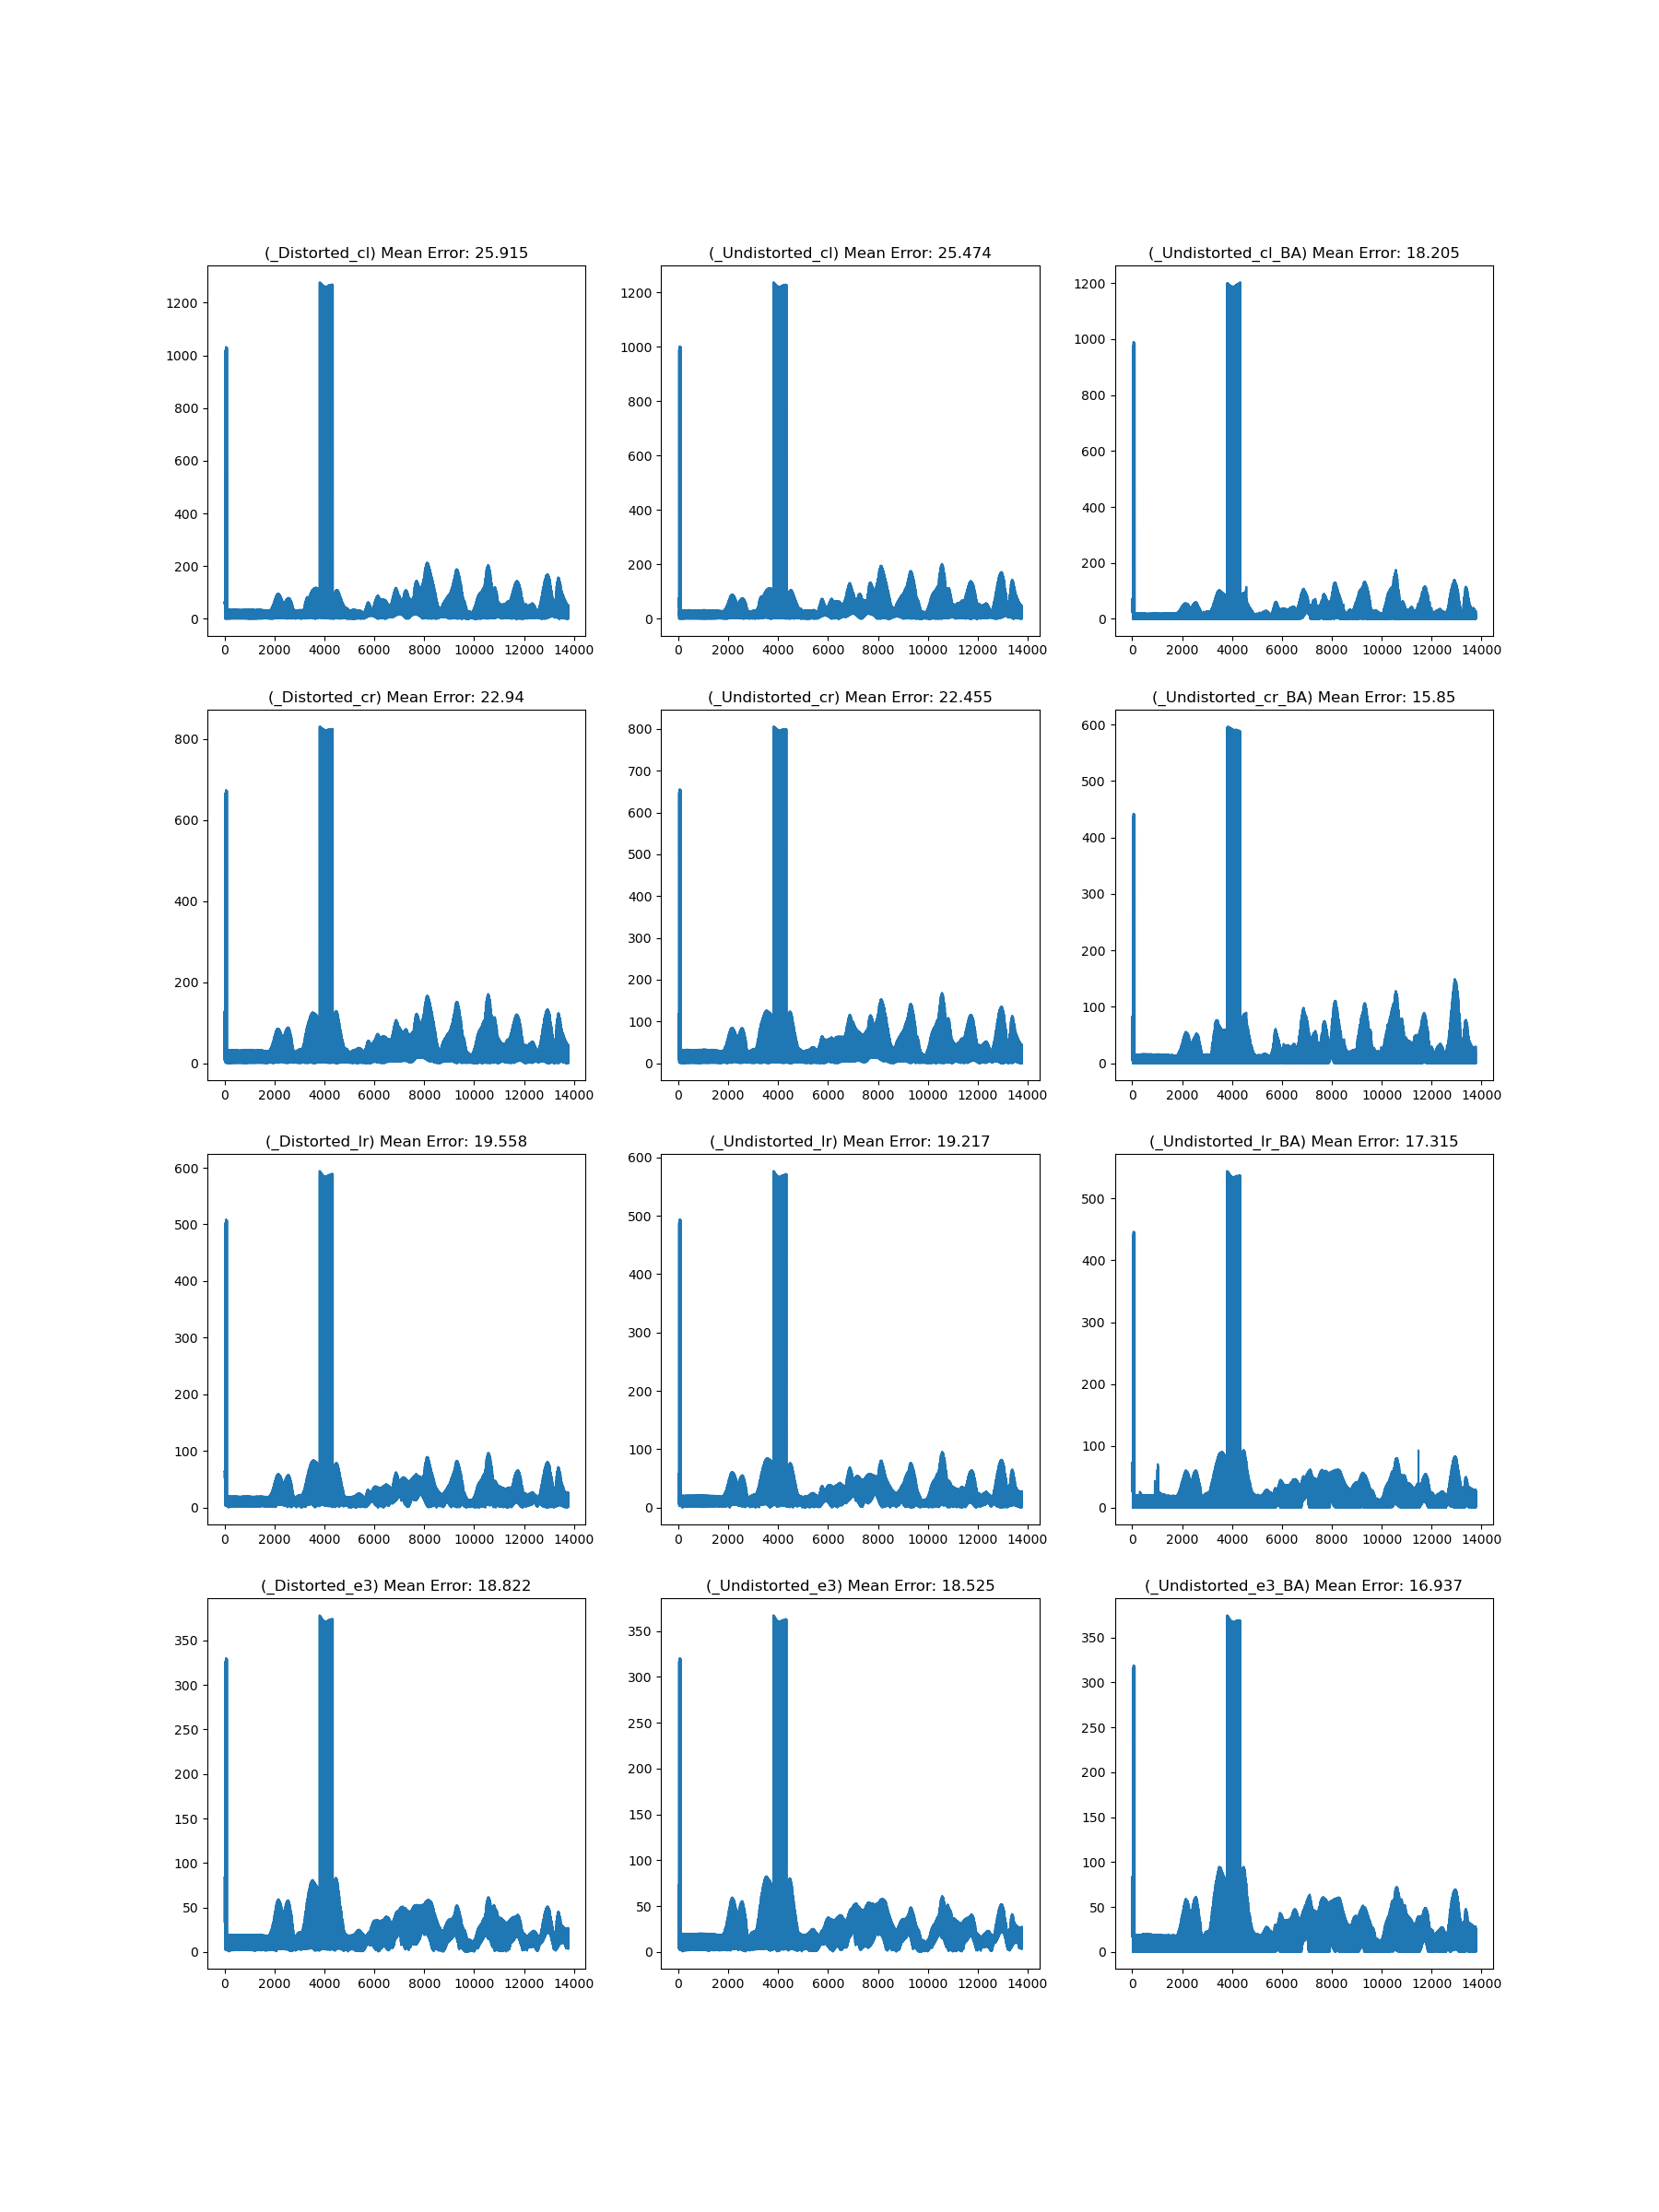

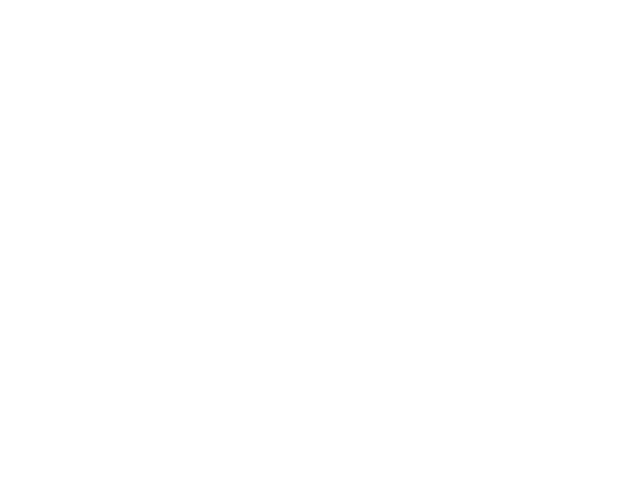

In [265]:
plt.clf()
fig, ax = plt.subplots(figsize=(18, 24),nrows=4, ncols=3)
#fig.tight_layout(pad=5.0)
ax[0,0].plot(np.arange(len(lossu1)),lossu1)
ax[1,0].plot(np.arange(len(lossu2)),lossu2)
ax[2,0].plot(np.arange(len(lossu3)),lossu3)
ax[3,0].plot(np.arange(len(lossu4)),lossu4)

ax[0,1].plot(np.arange(len(loss2)), loss2)
ax[1,1].plot(np.arange(len(loss3)),loss3)
ax[2,1].plot(np.arange(len(loss4)),loss4)
ax[3,1].plot(np.arange(len(loss5)),loss5)

ax[0,2].plot(np.arange(len(loss6)),loss6)
ax[1,2].plot(np.arange(len(loss7)),loss7)
ax[2,2].plot(np.arange(len(loss8)),loss8)
ax[3,2].plot(np.arange(len(loss9)),loss9)

ax[0,0].set_title('(_Distorted_cl) Mean Error: ' + str(round(np.mean(lossu1),3)))
ax[1,0].set_title('(_Distorted_cr) Mean Error: '+ str(round(np.mean(lossu2),3)))
ax[2,0].set_title('(_Distorted_lr) Mean Error: '+ str(round(np.mean(lossu3),3)))
ax[3,0].set_title('(_Distorted_e3) Mean Error: '+ str(round(np.mean(lossu4),3)))

ax[0,1].set_title('(_Undistorted_cl) Mean Error: ' + str(round(np.mean(loss2),3)))
ax[1,1].set_title('(_Undistorted_cr) Mean Error: '+ str(round(np.mean(loss3),3)))
ax[2,1].set_title('(_Undistorted_lr) Mean Error: '+ str(round(np.mean(loss4),3)))
ax[3,1].set_title('(_Undistorted_e3) Mean Error: '+ str(round(np.mean(loss5),3)))

ax[0,2].set_title('(_Undistorted_cl_BA) Mean Error: '+ str(round(np.mean(loss6),3)))
ax[1,2].set_title('(_Undistorted_cr_BA) Mean Error: '+ str(round(np.mean(loss7),3)))
ax[2,2].set_title('(_Undistorted_lr_BA) Mean Error: '+ str(round(np.mean(loss8),3)))
ax[3,2].set_title('(_Undistorted_e3_BA) Mean Error: '+ str(round(np.mean(loss9),3)))

print('Mean Error _Distorted_cl :', np.mean(lossu1))
print('Mean Error _Distorted_cr :', np.mean(lossu2))
print('Mean Error _Distorted_lr :', np.mean(lossu3))
print('Mean Error _Distorted_e3 :', np.mean(lossu4))
print('Mean Error _Undistorted_cl :', np.mean(loss2))
print('Mean Error _Undistorted_cr :', np.mean(loss3))
print('Mean Error _Undistorted_lr :', np.mean(loss4))
print('Mean Error _Undistorted_e3 :', np.mean(loss5))
print('Mean Error _Undistorted_cl_BA :', np.mean(loss6))
print('Mean Error _Undistorted_cr_BA :', np.mean(loss7))
print('Mean Error _Undistorted_lr_BA :', np.mean(loss8))
print('Mean Error _Undistorted_e3_BA :', np.mean(loss9))

plt.show()
fig.savefig('./output/k4/'+file+'_loss_fig.png')


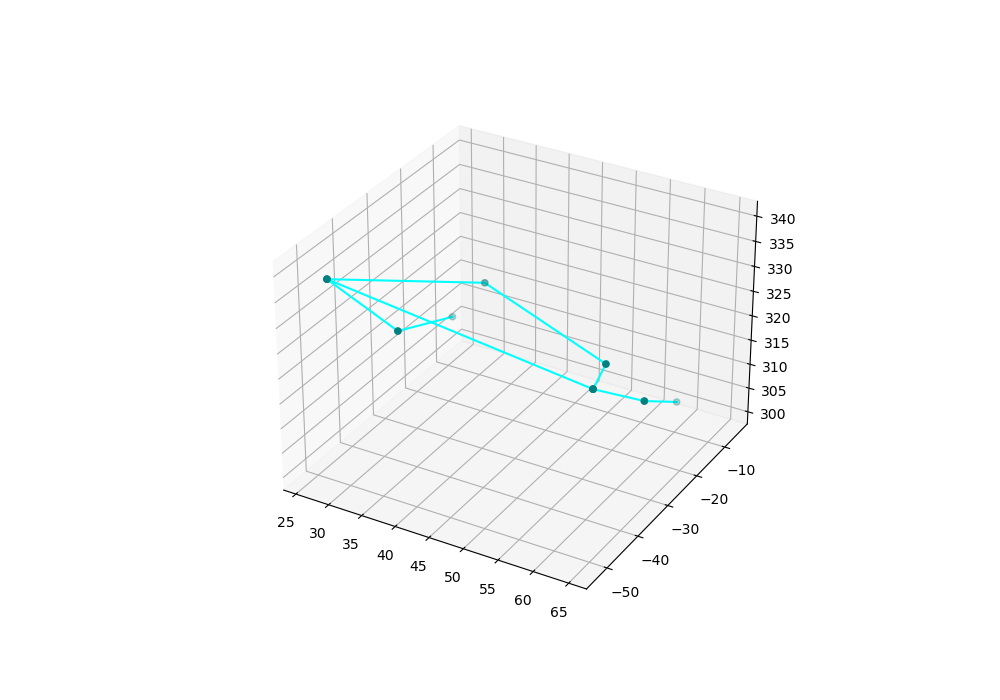

In [121]:
## Without BA

# outplotvid = "./output/k4/"+file+"_cl_ba"+".mp4"
# plot_3d(outdata3,outplotvid)

# outplotvid = "./output/k4/"+file+"_e3_ba"+".mp4"
# plot_3d(outdata5,outplotvid)

# outplotvid = "./output/k4/"+file+"_lr_ba"+".mp4"
# plot_3d(outdata6,outplotvid)

# outplotvid = "./output/k4/"+file+"_cr_ba"+".mp4"
# plot_3d(outdata7,outplotvid)

## With BA

# outplotvid = "./output/k4/"+file+"_cl_ba"+".mp4"
# plot_3d(outdata3,outplotvid)

# outplotvid = "./output/k4/"+file+"_e3_ba"+".mp4"
# plot_3d(outdata5,outplotvid)

# outplotvid = "./output/k4/"+file+"_lr_ba"+".mp4"
# plot_3d(outdata6,outplotvid)

# outplotvid = "./output/k4/"+file+"_cr_ba"+".mp4"
# plot_3d(outdata7,outplotvid)

# **Back-Projection**

In [32]:
def project_back(image, p2ds, p3ds, camera_index, show=False):

    _im = image
    #_im = cv2.imread(image, 1)
    height, width, channels = image.shape


    if camera_index == 'l':
        imgp, _ = cv2.projectPoints(p3ds, R1, T1, mtx_m, None)
        newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx_m, dist_m, (width,height), 1, (width,height))
        dst = cv2.undistort(_im, mtx_m, dist_m, None, newcameramtx)
    elif camera_index == 'c':
        imgp, _ = cv2.projectPoints(p3ds, np.eye(3), np.zeros(3), mtx_j, None)
        newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx_j, dist_j, (width,height), 1, (width,height))
        dst = cv2.undistort(_im, mtx_j, dist_j, None, newcameramtx)
    elif camera_index == 'r':
        imgp, _ = cv2.projectPoints(p3ds, R2, T2, mtx_w, None)
        newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx_w, dist_w, (width,height), 1, (width,height))
        dst = cv2.undistort(_im, mtx_w, dist_w, None, newcameramtx)
        
        
    imgp = np.squeeze(imgp)
    for c in imgp:
        cv2.circle(dst, (int(c[0]),int(c[1])), 
                    radius=5, color=(255,255,0), thickness=-1)
    for c in p2ds:
        cv2.circle(dst, (int(c[0]),int(c[1])), 
                radius=3, color=(0,255,0), thickness=-1)
    if show :     
        
        cv2.namedWindow('img')        # Create a named window
        cv2.moveWindow('img', 0,0)  # Move it to (40,30)
        cv2.imshow('img', dst)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return dst
    

In [33]:
def vizualize_projection(invideofile, outvideofile, data2d, data3d, camera_index, show=True, out_video=True):
    video = cv2.VideoCapture(invideofile)
   
    frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    size = (frame_width,frame_height)
    print(size)

    fourcc = cv2.VideoWriter_fourcc(*'MJPG') 
    video_write=cv2.VideoWriter(outvideofile,fourcc,10,size)
    
    i = 1
    while(True):
        ret, frame = video.read()

        if ret == True and i <= len(data2d): 
            

            p3ds = []
            for c, v in data3d[i].items():
                p3ds.append(v)
            p3ds = np.array(p3ds)
                
            p2ds = []
            for c, v in data2d[i].items():
                p2ds.append(v[camera_index])
            p2ds = np.array(p2ds)
            
            projection = project_back(frame, p2ds, p3ds, camera_index, show=False)

            if out_video:
                video_write.write(projection)
    
            if show:
                cv2.namedWindow('img')        # Create a named window
                cv2.moveWindow('img', 0,0)  # Move it to (40,30)
                cv2.imshow('img', projection)

                # to stop the process
                if cv2.waitKey(0) & 0xFF == ord('q'):
                    show = False
                    cv2.destroyAllWindows()
        else:
            break
        i += 1

    cv2.destroyAllWindows()
    # When everything done, release 
    # the video capture and video 
    # write objects
    video.release()
    video_write.release()
        
    # Closes all the frames


# Do The Back Projection

In [44]:

with open(infile,'rb') as handle:
    data2d = pickle.load(handle)
vizualize_projection('./data/k4/m/VID_DefaultPose.mp4','./output/k4/VID_DefaultPose'+'viz_l_cr_ba'+'.avi',data2d,outdata9,'l',show=False)

(1920, 1080)


In [30]:
# inpicks = [ 'input/k3/outputPickle_foto_default_pose',
#  'input/k3/outputPickle_foto_default_pose_1',
#  'input/k3/outputPickle_foto_default_pose_2',
#  'input/k3/outputPickle_foto_default_pose_3',
#  'input/k3/outputPickle_foto_default_pose_4',
#  'input/k3/outputPickle_foto_default_pose_pin',
#  'input/k3/outputPickle_foto_default_pose_pin_1',
#  'input/k3/outputPickle_foto_default_pose_pin_2',
#  'input/k3/outputPickle_foto_default_pose_pin_3',
#  'input/k3/outputPickle_foto_default_pose_pin_4',
#  'input/k3/outputPickle_foto_default_pose_pin_5']

# outpicks = ['./output/k3/pickle/output3dPickle_foto_default_pose',  # 0
#  './output/k3/pickle/output3dPickle_foto_default_pose_1', # 1
#  './output/k3/pickle/output3dPickle_foto_default_pose_2', # 2
#  './output/k3/pickle/output3dPickle_foto_default_pose_3', # 3
#  './output/k3/pickle/output3dPickle_foto_default_pose_4', # 4
#  './output/k3/pickle/output3dPickle_foto_default_pose_pin', # 5
#  './output/k3/pickle/output3dPickle_foto_default_pose_pin_1',
#  './output/k3/pickle/output3dPickle_foto_default_pose_pin_2',
#  './output/k3/pickle/output3dPickle_foto_default_pose_pin_3',
#  './output/k3/pickle/output3dPickle_foto_default_pose_pin_4',
#  './output/k3/pickle/output3dPickle_foto_default_pose_pin_5'
#  ]

# outdataks = []
# for i in range(len(inpicks)):
#     outdataks.append(triangulate_pickle(inpicks[i],outpicks[i]+"_Undistorted_e3",undistort=True,main_stereo_camera = 'cl',with_BA=True,dump_pickle = False))

`ftol` termination condition is satisfied.
Function evaluations 61, initial cost 7.4192e+01, final cost 5.4931e+00, first-order optimality 3.92e+02.
`ftol` termination condition is satisfied.
Function evaluations 76, initial cost 1.1896e+02, final cost 2.7886e+01, first-order optimality 3.88e+02.
`ftol` termination condition is satisfied.
Function evaluations 100, initial cost 1.0388e+02, final cost 2.4792e+01, first-order optimality 6.61e+02.
`ftol` termination condition is satisfied.
Function evaluations 122, initial cost 1.0023e+02, final cost 1.2541e+01, first-order optimality 2.99e+02.
`ftol` termination condition is satisfied.
Function evaluations 131, initial cost 1.0622e+02, final cost 6.6884e+00, first-order optimality 1.98e+02.
`ftol` termination condition is satisfied.
Function evaluations 68, initial cost 7.1873e+01, final cost 5.9587e+00, first-order optimality 2.49e+02.
`ftol` termination condition is satisfied.
Function evaluations 77, initial cost 1.2954e+02, final cost

In [31]:
# im_srcs =['./data/k3/j/IMG_default_pose.jpg',
#            './data/k3/j/IMG_default_pose_1.jpg',
#             './data/k3/j/IMG_default_pose_2.jpg',
#             './data/k3/j/IMG_default_pose_3.jpg',
#             './data/k3/j/IMG_default_pose_4.jpg',
#             './data/k3/j/IMG_default_pose_pin.jpg',
#             './data/k3/j/IMG_default_pose_pin_1.jpg',
#             './data/k3/j/IMG_default_pose_pin_2.jpg',
#             './data/k3/j/IMG_default_pose_pin_3.jpg',
#             './data/k3/j/IMG_default_pose_pin_4.jpg',
#             './data/k3/j/IMG_default_pose_pin_5.jpg']

# for i in range(len(im_srcs)):
#     data2d = []
#     data3d = []
#     for c, v in outdataks[i][1].items():
#         data3d.append(v)
        
#     with open(inpicks[i], 'rb') as file:
#         data = pickle.load(file)
        
#     for col, cam in data[1].items():
#         data2d.append(cam['c']) 
       
#     project_back(cv2.imread(im_srcs[i], 1), np.array(data2d),np.array(data3d),'c',True)
    
    

# **Additional Evaluation**

In [20]:

def get_chessboard_coordinate(image,row = 5, col = 7, scale= 4.5, show=True):

    _im = cv2.imread(image, 1)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)

    rows = row 
    columns = col 
    world_scaling = scale 

    objp = np.zeros((rows*columns,3), np.float32)
    objp[:,:2] = np.mgrid[0:rows,0:columns].T.reshape(-1,2)
    objp = world_scaling* objp


    width = _im.shape[1]
    height = _im.shape[0]

    #Pixel coordinates of checkerboards
    imgpoints = [] # 2d points in image plane.


    #coordinates of the checkerboard in checkerboard world space.
    objpoints = [] # 3d point in real world space
   
    gray = cv2.cvtColor(_im, cv2.COLOR_BGR2GRAY)

    detectChessboardflags = (cv2.CALIB_CB_ACCURACY  
    + cv2.CALIB_CB_EXHAUSTIVE  
    + cv2.CALIB_CB_NORMALIZE_IMAGE)

    c_ret, corners = cv2.findChessboardCornersSB(gray, (rows, columns), detectChessboardflags)

    if c_ret == True :

        corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

        cv2.drawChessboardCorners(_im, (rows, columns), corners, c_ret)      
        
        if show:
            cv2.imshow('img', _im)
        cv2.waitKey(0)
        

        objpoints.append(objp)
        imgpoints.append(corners)

    cv2.destroyAllWindows()
    
    return np.squeeze(imgpoints)


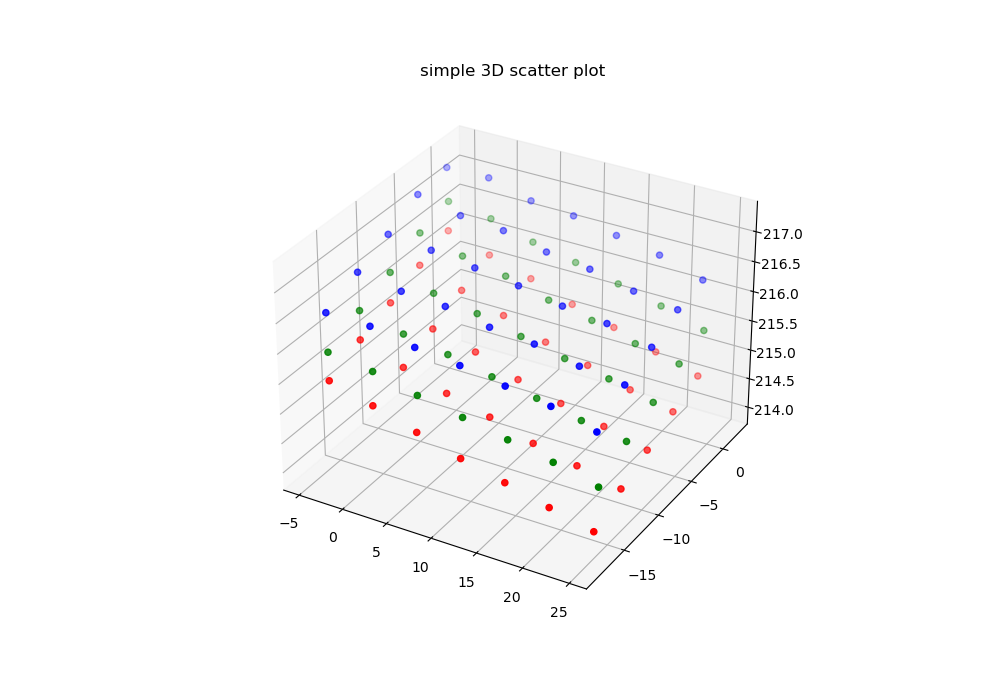

In [56]:
# Import libraries
%matplotlib widget
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
plt.title("simple 3D scatter plot")

usv_c = get_chessboard_coordinate('./data/k/j/tritest/calboard.jpg',show=False)
usv_l = get_chessboard_coordinate('./data/k/m/tritest/calboard.jpg',show=False)
usv_r = get_chessboard_coordinate('./data/k/w/tritest/calboard.jpg',show=False)

p3ds_cl = triangulate(mtx_j,mtx_m,None,None,R1,T1,usv_c,usv_l)
p3ds_cr = triangulate(mtx_j,mtx_w,None,None,R2,T2,usv_c,usv_r)
p3ds_lr = triangulate(mtx_m,mtx_w,R1,T1,R2,T2,usv_l,usv_r)

x = p3ds_cl[:,0]
y = p3ds_cl[:,1]
z = p3ds_cl[:,2]
ax.scatter3D(x, y, z, color = "red")

x = p3ds_cr[:,0]
y = p3ds_cr[:,1]
z = p3ds_cr[:,2]
ax.scatter3D(x, y, z, color = "blue")

x = p3ds_lr[:,0]
y = p3ds_lr[:,1]
z = p3ds_lr[:,2]
ax.scatter3D(x, y, z, color = "green")

#plt.show()


In [53]:
print(np.linalg.norm(p3ds_cl[0]-p3ds_cl[1]))
print(np.linalg.norm(p3ds_cr[0]-p3ds_cr[1]))
print(np.linalg.norm(p3ds_lr[0]-p3ds_lr[1]))
print(np.linalg.norm(p3ds_cl[0]-p3ds_cr[0]))
print(np.linalg.norm(p3ds_cr[0]-p3ds_lr[0]))
print(np.linalg.norm(p3ds_cl[0]-p3ds_lr[0]))

4.527597411278261
4.512336481051278
4.549887493292189
1.0809475786200735
0.7433814116924612
0.7673242804741763


In [80]:

np.squeeze([-1,-1,-1])

array([-1, -1, -1])

In [33]:
# usv_c = reproject_back('./data/k/j/tritest/calboard.jpg',p3ds_cl,'c')
# usv_c = reproject_back('./data/k/j/tritest/calboard.jpg',p3ds_cr,'c')
# usv_c = reproject_back('./data/k/j/tritest/calboard.jpg',p3ds_lr,'c')
# usv_l = reproject_back('./data/k/m/tritest/calboard.jpg',p3ds_cl,'l')
# usv_r = reproject_back('./data/k/w/tritest/calboard.jpg',p3ds_lr,'r')


In [ ]:
import numpy as np
import cv2

def get_centerpoints(img,lh=28,ls=20,lv=20,uh=160,us=255,uv=255):
    # Define Trackbar On Change Value
    def do_nothing(x):
        pass

    # Init Empty Black Image To Describe Lower limit and Upper limit for Color Detection
    L_img = np.zeros((480, 640, 3), np.uint8)
    U_img = np.zeros((480, 640, 3), np.uint8)

    # Init Windows
    cv2.namedWindow("Res",cv2.WINDOW_NORMAL)
    cv2.namedWindow("HSV Control",cv2.WINDOW_NORMAL)

    # Init Trackbar for Setting Lower Limit and Upper Limit Of HSV Detection
    cv2.createTrackbar("Lower Hue","HSV Control"        ,lh,179,do_nothing)
    cv2.createTrackbar("Lower Saturation","HSV Control" ,ls,255,do_nothing)
    cv2.createTrackbar("Lower Value","HSV Control"      ,lv,255,do_nothing)
    cv2.createTrackbar("Upper Hue","HSV Control"        ,uh,179,do_nothing)
    cv2.createTrackbar("Upper Saturation","HSV Control" ,us,255,do_nothing)
    cv2.createTrackbar("Upper Value","HSV Control"      ,uv,255,do_nothing)

    # Define Windows Initial Position
    cv2.moveWindow("Res",50,100)
    cv2.moveWindow("HSV Control",475,100)

    # Read Stream
    while(1):
        
        imageFrame = cv2.imread(img)   
    
        
        # Assign Trackbar value to variable
        L_H = cv2.getTrackbarPos("Lower Hue","HSV Control")
        L_S = cv2.getTrackbarPos("Lower Saturation","HSV Control")
        L_V = cv2.getTrackbarPos("Lower Value","HSV Control")    
        
        U_H = cv2.getTrackbarPos("Upper Hue","HSV Control")
        U_S = cv2.getTrackbarPos("Upper Saturation","HSV Control")
        U_V = cv2.getTrackbarPos("Upper Value","HSV Control")
        
        # Assert Boundaries
        if L_H > U_H:
            L_H = U_H
        if L_S > U_S:
            L_S = U_S
        if L_V > U_V:
            L_V = U_V
            
            
        L_limit=np.array([L_H,L_S,L_V]) # setting the lower limit
        U_limit=np.array([U_H,U_S,U_V]) # setting the upper limit
            
        # Convert Image To HSV
        into_hsv =cv2.cvtColor(imageFrame,cv2.COLOR_BGR2HSV)
        
        # Blur to reduce Noise
        into_hsv = cv2.blur(into_hsv,(7,7))
        
        # Create Mask
        b_mask=cv2.inRange(into_hsv,L_limit,U_limit)
        
        
        # Reduce Mask Splitting on same region
        kernel = np.ones((5, 5), np.uint8)
        b_mask = cv2.dilate(b_mask, kernel, iterations=3)

        # creating the mask using inRange() function
        # this will produce an image where the color of the objects
        # falling in the range will turn white and rest will be black
        #imageFrame=cv2.bitwise_and(imageFrame,imageFrame,mask=fgmask)
        
        blue=cv2.bitwise_and(imageFrame,imageFrame,mask=b_mask)
        
        
        L_img[:] = [L_H,L_S,L_V]
        U_img[:] = [U_H,U_S,U_V]
        L_img = cv2.cvtColor(L_img,cv2.COLOR_HSV2BGR)
        U_img = cv2.cvtColor(U_img,cv2.COLOR_HSV2BGR)
        outputControl = np.concatenate((L_img,U_img),axis=1)
        
        contours, hierarchy = cv2.findContours(b_mask,
                                            cv2.RETR_TREE,
                                            cv2.CHAIN_APPROX_SIMPLE)
        centerpoints = []
        for pic, contour in enumerate(contours):
            area = cv2.contourArea(contour)
            if(area > 300):
                x, y, w, h = cv2.boundingRect(contour)
                imageFrame = cv2.rectangle(imageFrame, (x, y),
                                        (x + w, y + h),
                                        (255, 0, 0), 2)
                centerpoint = (x + w//2, y + h//2)
                centerpoints.append(centerpoint)
                # cv2.circle(imageFrame, centerpoint, 
                #         radius=3, color=(255,255,0), thickness=-1)
                cv2.putText(imageFrame, "Detected Object", (x, y),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1.0, (255, 0, 0))
        outputFrame = np.concatenate((imageFrame,blue),axis=1)
        
        
        cv2.imshow("Res", outputFrame)
        cv2.imshow("HSV Control",outputControl)
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break
    return centerpoints


In [ ]:
cc_1 = get_centerpoints('./data/triangulate/1/IMG_20230428_150246.jpg',10,110,160,160,255,225)
cc_2 = get_centerpoints('./data/triangulate/2/IMG_20230428_150245.jpg',23,120,125)
cc_1,cc_2

([(1535, 569), (1465, 558), (1343, 538), (1200, 518)],
 [(658, 573), (722, 570), (946, 561), (818, 563)])

In [ ]:
imageFrame = cv2.imread('./data/triangulate/1/IMG_20230428_150246.jpg')  
i=1
for c in cc_1:
    cv2.putText(imageFrame, str(i), c,
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1.0, (255, 0, 0))
    cv2.circle(imageFrame, c, 
        radius=3, color=(255,255,0), thickness=-1)
    i += 1
cv2.imshow('img', imageFrame)
cv2.waitKey(0)
cv2.destroyAllWindows()
i=1
imageFrame = cv2.imread('./data/triangulate/2/IMG_20230428_150245.jpg')  
for c in cc_2:
    cv2.putText(imageFrame, str(i), c,
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1.0, (255, 0, 0))
    
    cv2.circle(imageFrame, c, 
        radius=3, color=(255,255,0), thickness=-1)
    i+=1
cv2.imshow('img', imageFrame)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
cc_2[3], cc_2[2] = cc_2[2] , cc_2[3]

In [ ]:
PC = triangulate(mtx1,mtx2,R,T,cc_1,cc_2)
PC

Triangulated point: 
[365.43412575  23.68523481 923.34393261]
Triangulated point: 
[338.08346508  16.97533101 974.05555972]
Triangulated point: 
[ 277.97426509    3.10976788 1059.986938  ]
Triangulated point: 
[ 194.24253528  -12.7618975  1193.36846385]


array([[ 365.43412575,   23.68523481,  923.34393261],
       [ 338.08346508,   16.97533101,  974.05555972],
       [ 277.97426509,    3.10976788, 1059.986938  ],
       [ 194.24253528,  -12.7618975 , 1193.36846385]])

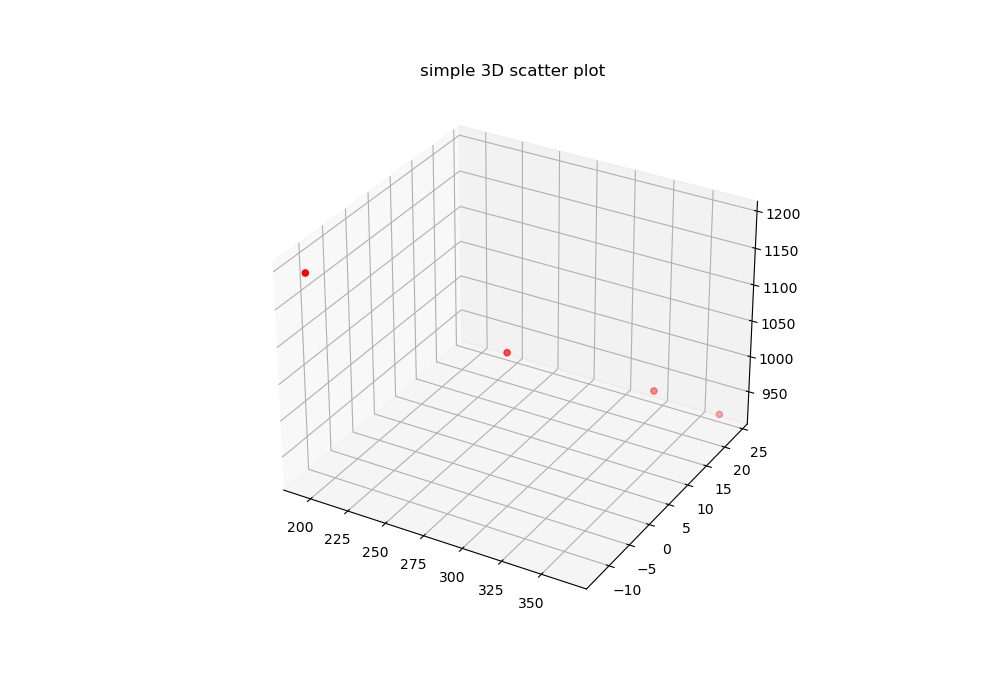

In [ ]:
# Import libraries
%matplotlib widget
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt


# Points
x = PC[:,0]
y = PC[:,1]
z = PC[:,2]

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(x, y, z, color = "red")
plt.title("simple 3D scatter plot")

# show plot
plt.show()


In [ ]:
print(np.linalg.norm(PC[0]-PC[1]))
print(np.linalg.norm(PC[1]-PC[2]))
print(np.linalg.norm(PC[2]-PC[3]))
print(np.linalg.norm(PC[0]-PC[3]))

58.00647008533676
105.78077111796546
158.2831127365487
321.7890637885448
